In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.io as spio
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

In [2]:
# Read splicing data
df = pd.read_csv('Splicing_Data.txt', sep='\t')
df = df.loc[~np.isnan(df.SD1_Usage)].copy().reset_index(drop=True)

df = df.iloc[-10000:].copy().reset_index(drop=True)

df['Region1'] = df['Seqs'].str.slice(2, 37)

print('Size of splicing dataset = ' + str(len(df)))

Size of splicing dataset = 10000


In [3]:
# Generate 6mer feature matrix
mer6_dict = {}
mer6_list = []
bases = list('ACGT')

# Build dictionary of 6-mer -> index
i = 0
for b1 in bases :
    for b2 in bases :
        for b3 in bases :
            for b4 in bases :
                for b5 in bases :
                    for b6 in bases :
                        mer6_dict[b1 + b2 + b3 + b4 + b5 + b6] = i
                        mer6_list.append(b1 + b2 + b3 + b4 + b5 + b6)
                        i += 1

# Loop over dataframe, fill matrix X with 6-mer counts
X = sp.lil_matrix((len(df), len(mer6_dict)))
for index, row in df.iterrows() :
    if index % 2000 == 0 :
        print('Extracting 6-mer features from sequence ' + str(index))
    
    region1 = row['Region1']
    #Loop over all 6-mers in the current sequence
    for j in range(0, len(region1) - 6 + 1) :
        if region1[j:j+6] in mer6_dict :
            #Increment X at the corrposnding 6-mer index position
            X[index, mer6_dict[region1[j:j+6]]] += 1.

X = sp.csr_matrix(X)
y = np.ravel(df['SD1_Usage'].values)

print('Shape of X = ' + str(X.shape))
print('Shape of y = ' + str(y.shape))


Extracting 6-mer features from sequence 0
Extracting 6-mer features from sequence 2000
Extracting 6-mer features from sequence 4000
Extracting 6-mer features from sequence 6000
Extracting 6-mer features from sequence 8000
Shape of X = (10000, 4096)
Shape of y = (10000,)


In [69]:
# Problem 1.1
# Calculate log odds ratios of 6-mers using feature matrix X and splicing ratios y
X_col = sp.csc_matrix(X) # More efficient representation of X when working with columns
print(X_col.shape)

(10000, 4096)


In [8]:
# Helper function for computing log(x / y) in a safe way (whenever x or y is 0).
def safe_kl_log(num, denom):
    log_vec = np.zeros(num.shape)
    log_vec[(num > 0) & (denom > 0)] = np.log(num[(num > 0) & (denom > 0)] / denom[(num > 0) & (denom > 0)])
    return log_vec

In [7]:
logodds_ratios = np.zeros(X_col.shape[1])
y_has = np.zeros(X_col.shape[1])
y_not = np.zeros(X_col.shape[1])
        
# Loop over every 6-mer index
# Calculate and store the log odds ratio of each 6-mer in vector 'logodds_ratios'
for w_i in range(logodds_ratios.shape[0]) :
    if w_i % 1000 == 0:
        print('Calculating logodds for 6-mer ' + str(w_i) + '...')
        
    y_has_mul = np.nonzero(X[:, w_i])[0]
    y_not_mul = np.where(np.sum(X[:, w_i], axis = 1) == 0)[0]
    
    y_has[w_i] = np.sum(y[y_has_mul]) / X_col[:, w_i].size
    y_not[w_i] = (np.sum(y) - np.sum(y[y_has_mul])) / (10000 - X_col[:, w_i].size)
    
    if(y_has[w_i] == 0 or y_not[w_i] == 0):
        logodds_ratios[w_i] = 0
        continue
    num = y_has[w_i] / (1 - y_has[w_i])
    denum = y_not[w_i] / (1 - y_not[w_i])
    logodds_ratios[w_i] = safe_kl_log(num, denum)

Calculating logodds for 6-mer 0...
Calculating logodds for 6-mer 1000...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Calculating logodds for 6-mer 2000...
Calculating logodds for 6-mer 3000...
Calculating logodds for 6-mer 4000...


The largest value of the log odd ratios is 4.038562322892769 and the smallest is -4.3735585338842755


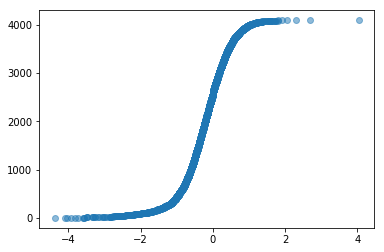

In [97]:
# Problem 1.1
# Plot the sorted Log odds ratios, and print the smallest and largest values
ind = np.argsort(logodds_ratios)
logodds_ratios.sort()
plt.scatter(logodds_ratios, ind, alpha = 0.5)
print(f"The largest value of the log odd ratios is {max(logodds_ratios)} and the smallest is {min(logodds_ratios)}")

What is the largest and smallest Log odds ratio you observe and what do these magnitudes mean mathematically (in words)?
The largest and the smallest log odds ratio are mentioned above.
They mean that the the element i is e ^ 4.0  more likely to be spliced at the plasmid j. The smallest j is e ^ -4.37 less likely to be spliced at.

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

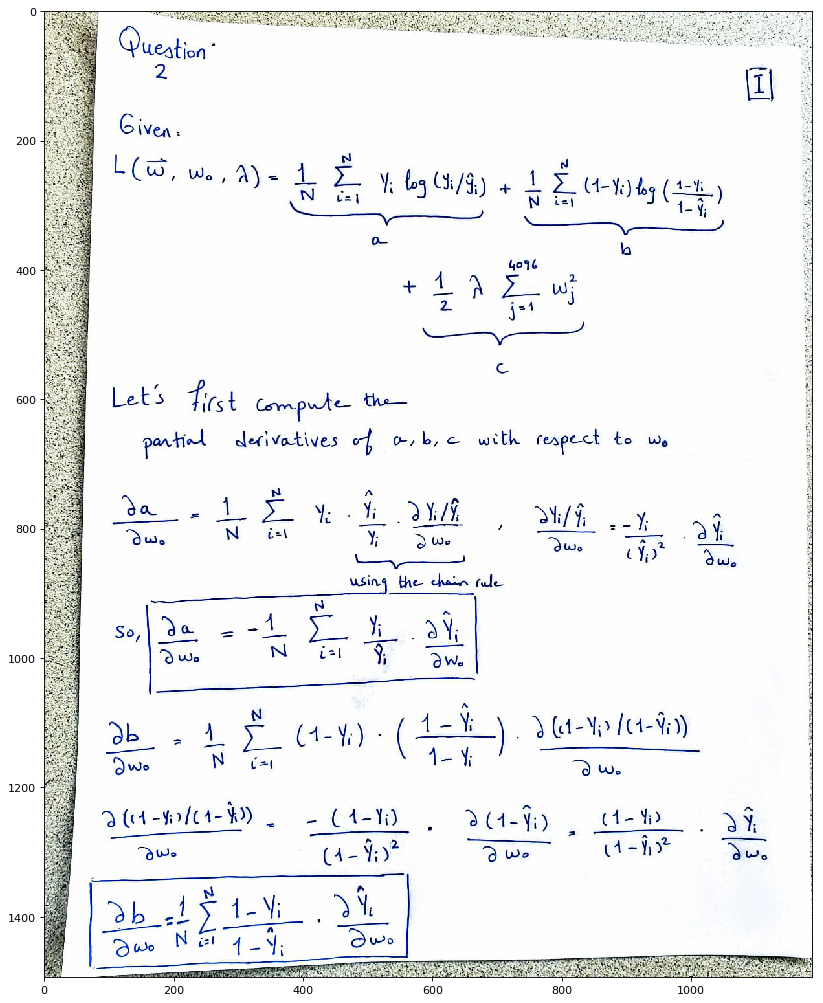

In [40]:
plt.figure(num=None, figsize=(24, 16), dpi=80, facecolor='w', edgecolor='k')
image = mpimg.imread("Assignment 4 Question 2 Proof I.jpeg")
plt.imshow(image)
plt.show()

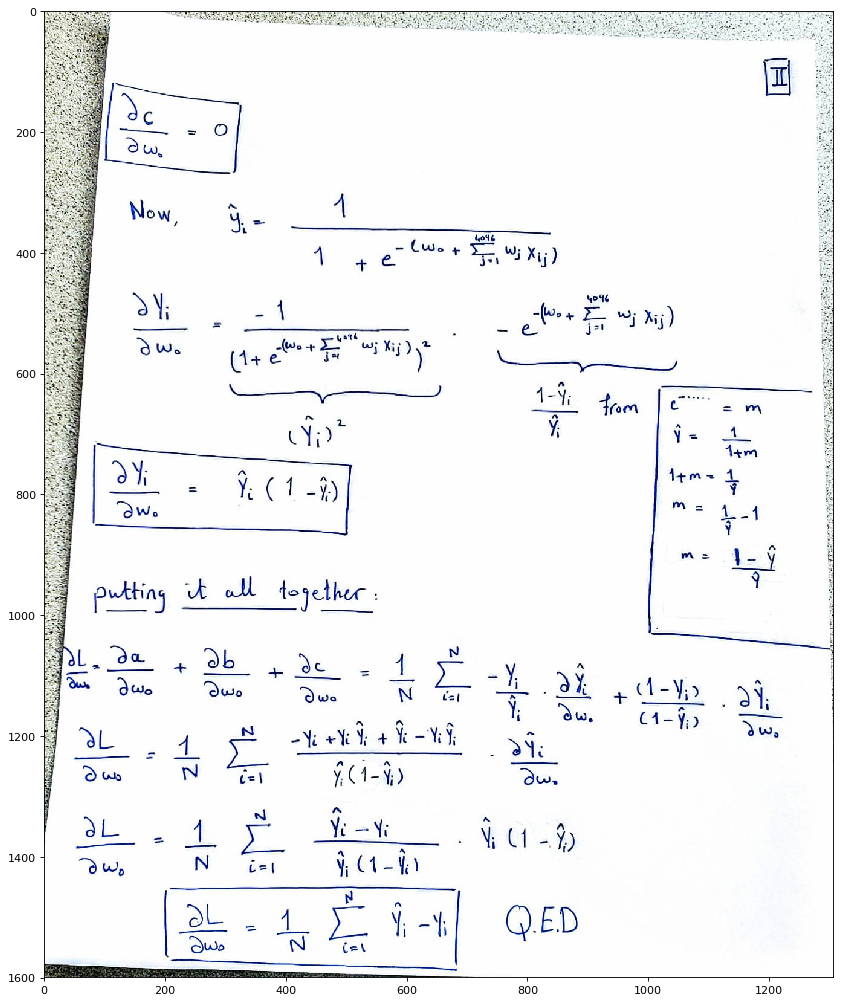

In [41]:
plt.figure(num=None, figsize=(24, 16), dpi=80, facecolor='w', edgecolor='k')
image = mpimg.imread("Assignment 4 Question 2 Proof II.jpeg")
plt.imshow(image)
plt.show()

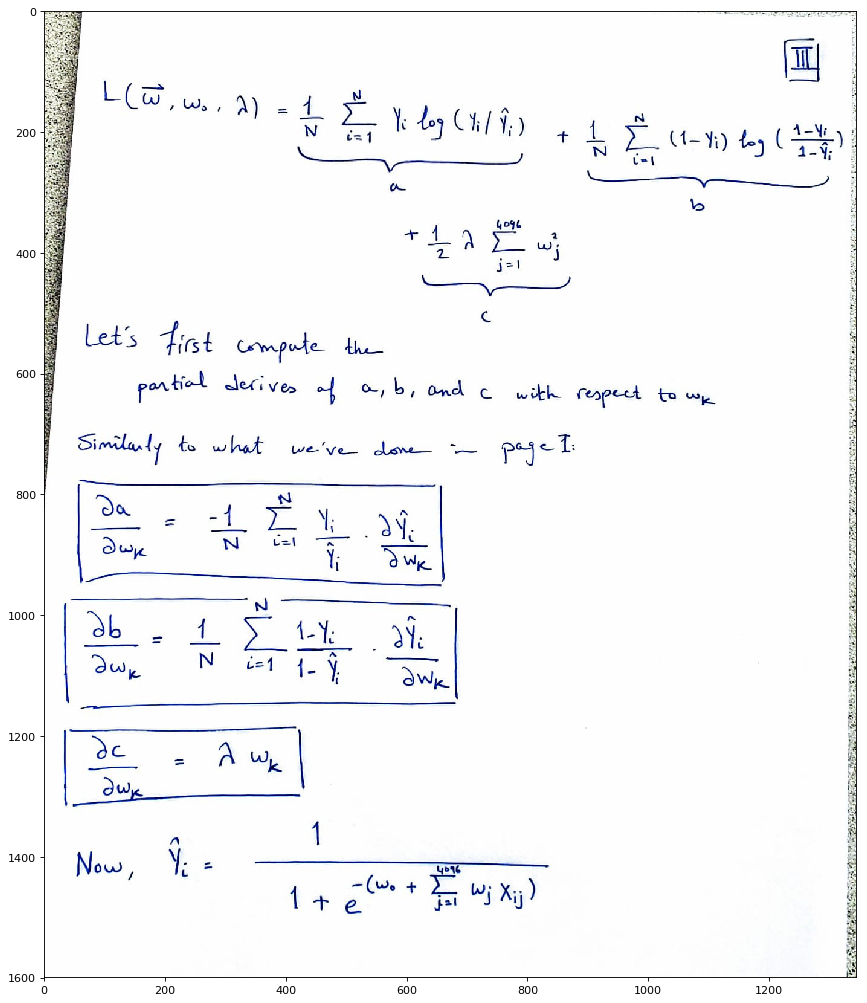

In [42]:
plt.figure(num=None, figsize=(24, 16), dpi=80, facecolor='w', edgecolor='k')
image = mpimg.imread("Assignment 4 Question 2 Proof III.jpeg")
plt.imshow(image)
plt.show()

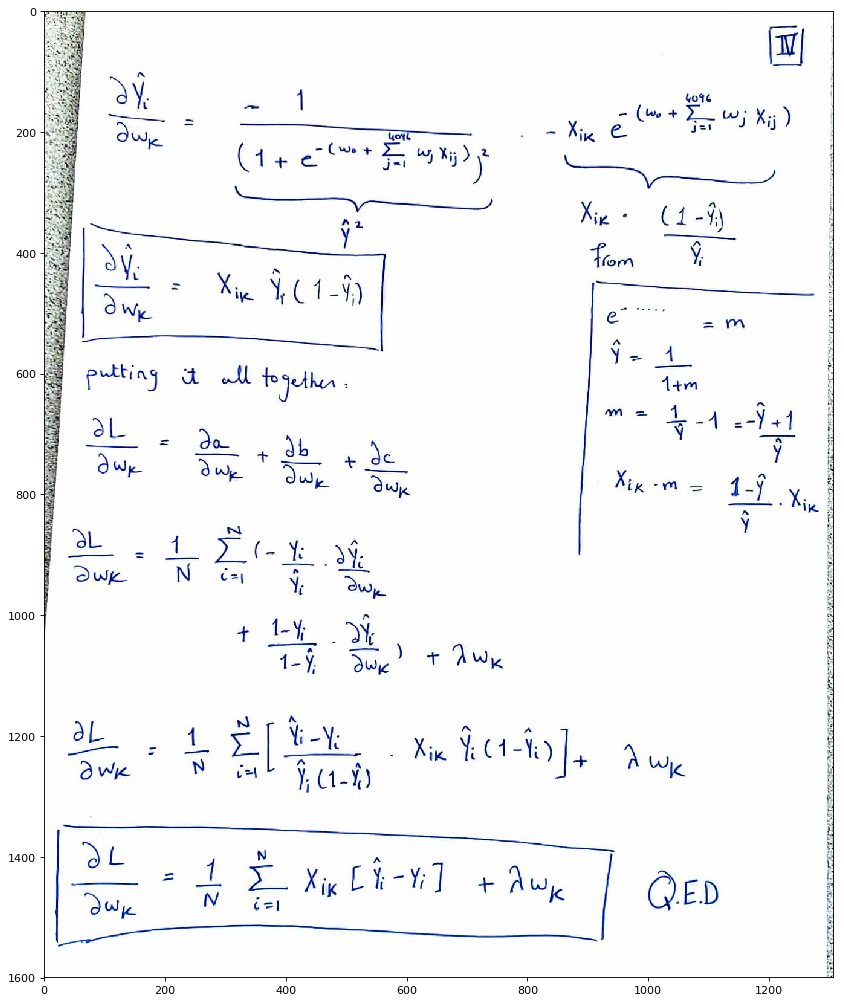

In [43]:
plt.figure(num=None, figsize=(24, 16), dpi=80, facecolor='w', edgecolor='k')
image = mpimg.imread("Assignment 4 Question 2 Proof IV.jpeg")
plt.imshow(image)
plt.show()

In [46]:
# Problem 1.3
# Split data (matrix X and vector y) into training and test sets. Test set should contain 2,000 data points
print(X.shape)
print(y.shape)
trainingSamples = 8000
X_train = X[0:trainingSamples, :]
y_train = y[0:trainingSamples]
X_test = X[trainingSamples:, :]
y_test = y[trainingSamples:]
print(X_test.shape)
print(y_test.shape)

(10000, 4096)
(10000,)
(2000, 4096)
(2000,)


In [91]:
# Problem 1.3
# Implement Gradient Descent with KL-divergence gradients for regressing splice site usages

# Compute the KL divergence loss (alpha is regularization parameter)
def kl_divergence_loss(X, w, w_0, y_true, alpha = 0.0001):
    y_hat = 1 / (1 + np.exp(-(w_0 + X * w)))
    N = X.shape[0]
    first_term = np.sum(y_true * safe_kl_log(y_true, y_hat)) / N
    second_term = np.sum((1 - y_true) * safe_kl_log(1 - y_true, 1 - y_hat)) / N
    return first_term + second_term + 1/2 * alpha * np.sum(w * w) 

# Compute the KL divergence gradients for the weight vector w and intercept term w_0 (alpha is regularization parameter)
def kl_divergence_gradients(X, w, w_0, y_true, alpha = 0.0001):
    # Return kl divergence loss gradients for w and w_0
    N = X.shape[0]
    y_hat = 1 / (1 + np.exp(-(w_0 + X * w)))
    w_new_gradient = X.T *(y_hat - y_true) / N + alpha * w
    w_0_new_gradient = np.sum((y_hat - y_true)) / N
    return w_new_gradient, w_0_new_gradient

# Gradient Descent algorithm to optimize weights w and w_0
def gradient_descent(X_train, y_train, X_test, y_test, w, w_0, step_size = 0.1, alpha = 0.0001, max_epochs = 3000):
    mean_train_losses = []
    mean_test_losses = []
    for epoch in range(max_epochs) : # Stop after unreasonable # of iterations, in case we never converge
        if epoch % 100 == 1 and len(mean_train_losses) > 0 :
            print('Training epoch = ' + str(epoch))
            print('Training set KL-div = ' + str(round(mean_train_losses[-1], 4)))
            print('Test set KL-div = ' + str(round(mean_test_losses[-1], 4)))
        
        # Calculate the KL loss and gradients on the training set
        KL_loss_train = kl_divergence_loss(X_train, w, w_0, y_train, alpha)
        KL_loss_test = kl_divergence_loss(X_test, w, w_0, y_test, alpha)
        
        w_new_gradient, w_0_new_gradient = kl_divergence_gradients(X_train, w, w_0, y_train, alpha)
        
        # Update your weights w and w_0 based on the gradients
        w = w - step_size * w_new_gradient
        w_0 = w_0 - step_size * w_0_new_gradient
        
        # Append your mean train and test loss to 'mean_train_losses' and 'mean_test_losses'
        mean_train_losses.append(KL_loss_train)
        mean_test_losses.append(KL_loss_test)
        # Stop the loop once the training loss stops decreasing significantly
        if(epoch > 0):
            if ((mean_train_losses[-2] / mean_train_losses[-1]) < (1 + alpha)):
                print("Breaks at epoch: " + str(epoch))
                break
    
    print('Gradient descent completed.')
    print('Final training set KL-div = ' + str(round(mean_train_losses[-1], 4)))
    print('Final test set KL-div = ' + str(round(mean_test_losses[-1], 4)))
    
    return w, w_0, mean_train_losses, mean_test_losses

In [92]:
# Problem 1.3
# Here we initialize the weight vector and intercept term to zeros.
w, w_0 = np.zeros(X.shape[1]), 0

# Train the weights using your Gradient Descent algorithm
w, w_0, train_losses, test_losses = gradient_descent(X_train, y_train, X_test, y_test, w, w_0)

Training epoch = 1
Training set KL-div = 0.4482
Test set KL-div = 0.4385
Training epoch = 101
Training set KL-div = 0.2233
Test set KL-div = 0.235
Training epoch = 201
Training set KL-div = 0.1942
Test set KL-div = 0.208
Training epoch = 301
Training set KL-div = 0.1775
Test set KL-div = 0.1932
Training epoch = 401
Training set KL-div = 0.1662
Test set KL-div = 0.1835
Training epoch = 501
Training set KL-div = 0.1577
Test set KL-div = 0.1764
Training epoch = 601
Training set KL-div = 0.1511
Test set KL-div = 0.1709
Training epoch = 701
Training set KL-div = 0.1457
Test set KL-div = 0.1665
Training epoch = 801
Training set KL-div = 0.1412
Test set KL-div = 0.1628
Training epoch = 901
Training set KL-div = 0.1373
Test set KL-div = 0.1597
Training epoch = 1001
Training set KL-div = 0.1339
Test set KL-div = 0.157
Training epoch = 1101
Training set KL-div = 0.1309
Test set KL-div = 0.1547
Training epoch = 1201
Training set KL-div = 0.1283
Test set KL-div = 0.1526
Training epoch = 1301
Train

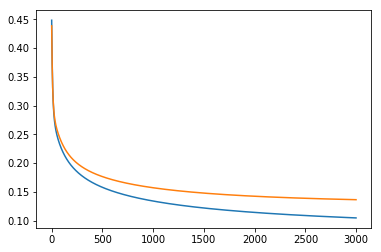

The pearson correlation coefficient is: 0.512945171721684


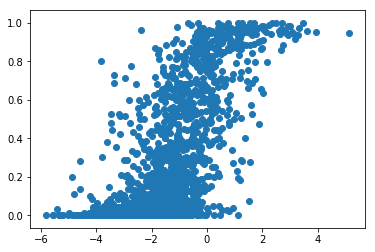

In [98]:
# Problem 1.3
# Plot training and test set loss (mean KL-div) vs. training iteration
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()
# Scatter plot of true vs. pred SD1 usage on test set, and print R^2 coefficient.
y_pred = ((X_test * w) + w_0)
plt.scatter(y_pred, y_test)
print(f"The pearson correlation coefficient is: {pearsonr(y_pred, y_test)[0] ** 2}")

In [82]:
test_losses[-10:]

[0.1427626612459782,
 0.14275501137254978,
 0.1427473681648531,
 0.1427397316153612,
 0.14273210171655853,
 0.14272447846094122,
 0.14271686184101648,
 0.14270925184930314,
 0.1427016484783314,
 0.14269405172064276]

Does your test set error ever start to increase?
No, it doesn't seem like it from the graph and from the manual check. I'm sure if we leave it long enough, it will start to go up again, but we do break before that.

In [78]:
# Problem 1.3
count = 10

# Plot the 10 6-mers and corresponding weights of largest magnitude
smallest_indices = w.argsort()[:count]
smallest_mer6 = [mer6_list[j] for j in smallest_indices]
print("The smallest 6mers are:")
print(smallest_mer6)

# Plot the 10 6-mers and corresponding weights of smallest magnitude
largest_indices = w.argsort()[-count:]
largest_mer6 = [mer6_list[j] for j in largest_indices]
print("The largest 6mers are:")
print(largest_mer6)

The smallest 6mers are:
['GGTAAG', 'CGGTCG', 'CTTGGA', 'AGGTAA', 'CTTGGT', 'AGAAGA', 'AAGGTA', 'GAAGAT', 'AAGAAG', 'CTTGGC']
The largest 6mers are:
['GGGGGA', 'TGGGGG', 'GGGGAG', 'AGGGGG', 'GGGGGT', 'GGTGGG', 'GGGTGG', 'GGAGGG', 'GGGAGG', 'GGGGGG']


For these most enhancing and repressive motifs, do you see any obvious trends or patterns?
I think the smallest ones have Ts in them while the largest ones are mostly Gs. Gs are really abundant.